1. Iniciando Simulación Cuántica (Dominio del Tiempo)...
2. Calculando Transformada de Fourier (FFT)...
 Energía detectada (Pico): 1.2441 


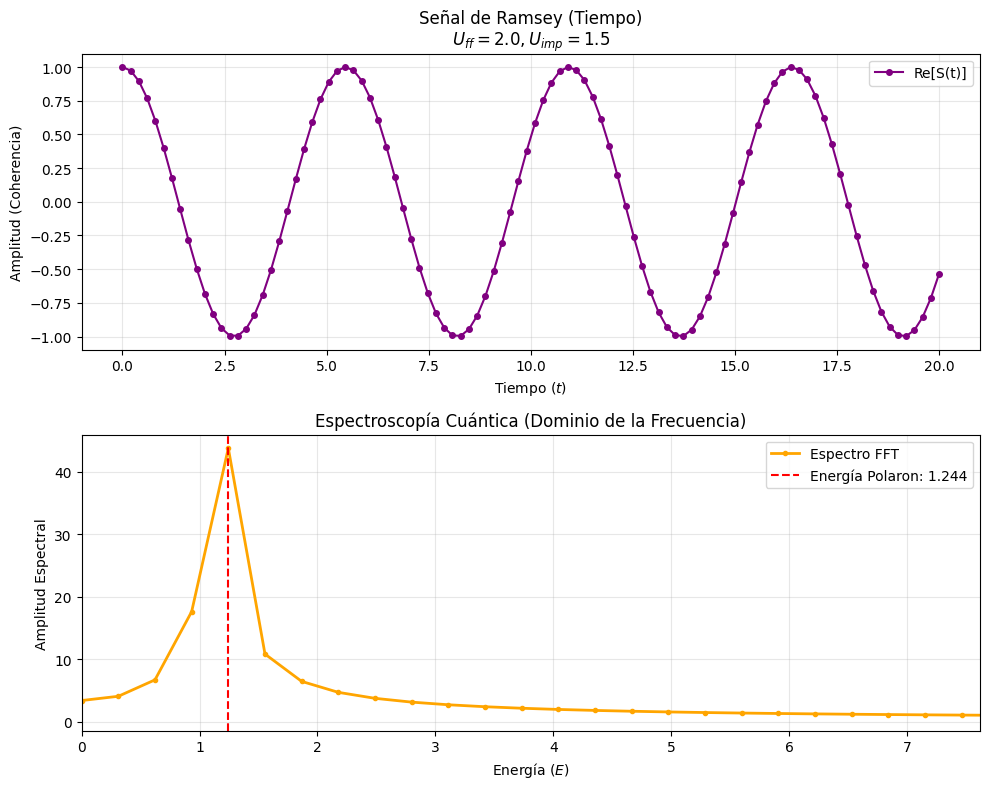

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# 1. CONFIGURACIÓN DEL SISTEMA

# Parámetros físicos (Modelo Polaron/BCS)
# Ajusta estos valores según la figura de tu TFG que quieras reproducir
eps_up   = 0.5   # Energía sitio spin-up
eps_down = 0.5   # Energía sitio spin-down
eps_d    = 0.2   # Energía de la impureza
U_ff     = 2.0   # Interacción fermión-fermión
U_imp    = 1.5   # Interacción impureza-baño

# Definición de Qubits
system_wires = [0, 1, 2]
ancilla_wire = 3
all_wires = system_wires + [ancilla_wire]


# 2. HAMILTONIANO Y TROTTERIZACIÓN MANUAL

def get_hamiltonian_data(eps_up, eps_down, eps_d, U_ff, U_imp):
    """Devuelve coeficientes y operadores para la evolución manual."""
    coeffs = []
    ops = []
    
    # Términos de un cuerpo (Energía de sitio)
    for w, eps in zip([0, 1, 2], [eps_up, eps_down, eps_d]):
        coeffs.append(-0.5 * eps)
        ops.append(qml.PauliZ(w))

    # Términos de interacción (ZZ)
    interactions = [(0, 1, U_ff), (2, 0, U_imp), (2, 1, U_imp)]
    for w1, w2, U in interactions:
        c = -0.25 * U
        coeffs.append(c)
        ops.append(qml.PauliZ(w1))
        coeffs.append(c)
        ops.append(qml.PauliZ(w2))
        
        c_zz = 0.25 * U
        coeffs.append(c_zz)
        ops.append(qml.PauliZ(w1) @ qml.PauliZ(w2))

    return coeffs, ops

coeffs, ops = get_hamiltonian_data(eps_up, eps_down, eps_d, U_ff, U_imp)

dev = qml.device("default.qubit", wires=all_wires)

def trotter_step(dt):
    """Aplica e^{-i H dt} usando puertas nativas RZ y MultiRZ."""
    for coeff, op in zip(coeffs, ops):
        theta = 2 * coeff * dt
        if len(op.wires) == 1:
            qml.ctrl(qml.RZ, control=ancilla_wire)(theta, wires=op.wires)
        else:
            qml.ctrl(qml.MultiRZ, control=ancilla_wire)(theta, wires=op.wires)

@qml.qnode(dev)
def ramsey_circuit(time, steps):
    # A. Preparación del Estado Base |110> (Bath lleno, Impureza vacía o llena según el caso)
    # NOTA: Para ver la energía del Polaron, idealmente deberías inicializar la impureza 
    # o comparar con el caso sin impureza. Aquí usamos |110> como en tu ejemplo anterior.
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    
    # B. Superposición Ancilla
    qml.Hadamard(wires=ancilla_wire)
    
    # C. Evolución Controlada
    if time > 0:
        dt = time / steps
        for _ in range(steps):
            trotter_step(dt)
            
    # D. Interferencia
    qml.Hadamard(wires=ancilla_wire)
    
    # E. Medida
    return qml.probs(wires=ancilla_wire)

# 3. EJECUCIÓN DE LA SIMULACIÓN

print("1. Iniciando Simulación Cuántica (Dominio del Tiempo)...")

# Aumentamos t_max y la resolución para tener una buena FFT
t_max = 20.0 
num_points = 100
times = np.linspace(0, t_max, num_points)
dt_sim = times[1] - times[0]

S_t_signal = []

for t in times:
    # Usamos 10 pasos de Trotter para buena precisión física
    probs = ramsey_circuit(t, steps=10)
    # Señal Ramsey = P(0) - P(1) = Re[S(t)]
    val = probs[0] - probs[1]
    S_t_signal.append(val)

S_t_signal = np.array(S_t_signal)

# 4. ANÁLISIS ESPECTRAL (FFT) - EL OBJETIVO

print("2. Calculando Transformada de Fourier (FFT)...")

# Calculamos FFT
fft_vals = np.fft.fft(S_t_signal)
freqs = np.fft.fftfreq(len(S_t_signal), d=dt_sim)

# Convertimos frecuencia f a Energía Angular (Omega = 2*pi*f)
# Esto asume h_bar = 1
energies = 2 * np.pi * freqs
amplitudes = np.abs(fft_vals)

# Filtramos solo frecuencias positivas
mask = energies >= 0
energies_pos = energies[mask]
amplitudes_pos = amplitudes[mask]

# Encontramos el pico (La energía del Polaron/Sistema)
peak_idx = np.argmax(amplitudes_pos)
polaron_energy = energies_pos[peak_idx]

print(f" Energía detectada (Pico): {polaron_energy:.4f} ")

# 5. VISUALIZACIÓN FINAL
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Gráfica 1: Oscilación en el Tiempo (Lo que ya tenías)
ax1.plot(times, S_t_signal, 'o-', color='purple', markersize=4, label="Re[S(t)]")
ax1.set_title(f"Señal de Ramsey (Tiempo)\n$U_{{ff}}={U_ff}, U_{{imp}}={U_imp}$")
ax1.set_xlabel("Tiempo ($t$)")
ax1.set_ylabel("Amplitud (Coherencia)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Gráfica 2: Espectro de Energía (Lo nuevo)
ax2.plot(energies_pos, amplitudes_pos, '.-', color='orange', linewidth=2, label="Espectro FFT")
ax2.axvline(polaron_energy, color='red', linestyle='--', label=f"Energía Polaron: {polaron_energy:.3f}")
ax2.set_title("Espectroscopía Cuántica (Dominio de la Frecuencia)")
ax2.set_xlabel("Energía ($E$)")
ax2.set_ylabel("Amplitud Espectral")
ax2.set_xlim(0, max(energies_pos)/2) # Zoom a la zona relevante
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()